In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools
from scipy.optimize import linear_sum_assignment
import os
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical # used for converting labels to one-hot-encoding
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten, Conv2D, MaxPool2D,Conv2DTranspose,Reshape
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import itertools
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from tensorflow.keras.initializers import VarianceScaling
from tensorflow.keras.optimizers import SGD

In [2]:
x_train = np.load('x_train.npy')
x_test = np.load('x_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')
y_test = [np.argmax(y)for y in y_test]
y_train = [np.argmax(y)for y in y_train]
x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
x=x.reshape((10015,22500))
print(x.shape)
train=False

(10015, 22500)


In [3]:
def acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_sum_assignment(w.max() - w)
    ind = np.asarray(ind)
    ind = np.transpose(ind)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [4]:
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

In [5]:
dims = [x.shape[-1], 5000, 3000, 2000,1000, 10]
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = SGD(lr=0.1, momentum=0.9)
pretrain_epochs = 150
batch_size = 20
autoencoder, encoder = autoencoder(dims, init=init)
autoencoder.summary()
print(dims)

Model: "AE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 22500)]           0         
_________________________________________________________________
encoder_0 (Dense)            (None, 5000)              112505000 
_________________________________________________________________
encoder_1 (Dense)            (None, 3000)              15003000  
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              6002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 1000)              2001000   
_________________________________________________________________
encoder_4 (Dense)            (None, 10)                10010     
_________________________________________________________________
decoder_4 (Dense)            (None, 1000)              11000    

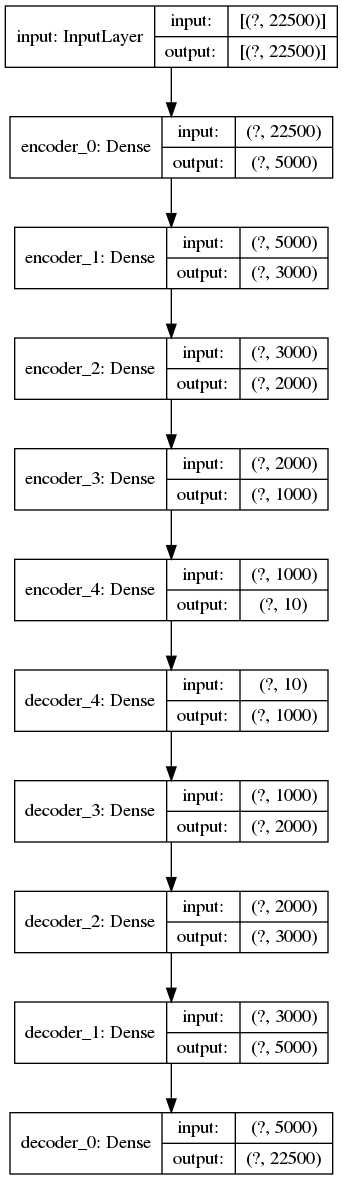

In [6]:
from tensorflow.keras.utils import plot_model
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='autoencoder.png') 

In [7]:
if train==True:
    autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
    history=autoencoder.fit(x,x, batch_size=batch_size, epochs=pretrain_epochs) #, callbacks=cb)
    autoencoder.save_weights('./ae_weights.h5')

In [8]:
autoencoder.load_weights('./ae_weights.h5')

In [9]:
class ClusteringLayer(keras.layers.Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = keras.layers.InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = keras.layers.InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [10]:
n_clusters = len(np.unique(y))
clustering_layer = ClusteringLayer(n_clusters=7,name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)
model.compile(optimizer=SGD(0.01,0.9), loss='kld')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 22500)]           0         
_________________________________________________________________
encoder_0 (Dense)            (None, 5000)              112505000 
_________________________________________________________________
encoder_1 (Dense)            (None, 3000)              15003000  
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              6002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 1000)              2001000   
_________________________________________________________________
encoder_4 (Dense)            (None, 10)                10010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 7)                 70    

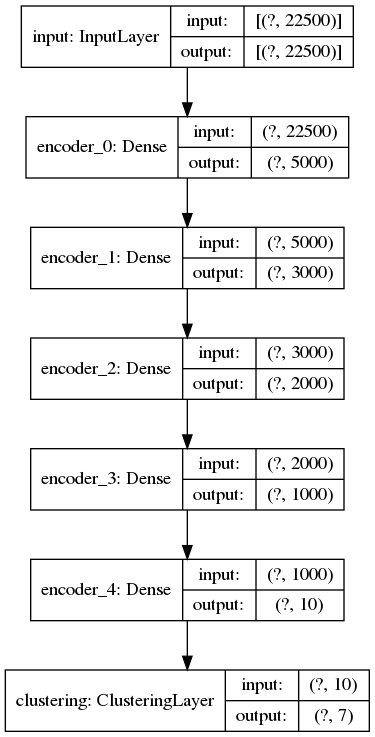

In [11]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png') 

In [12]:
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [14]:
autoencoder.load_weights('./ae_weights.h5')
print(n_clusters)
kmeans = KMeans(n_clusters=n_clusters)
y_pred = kmeans.fit_predict(encoder.predict(x))
y_pred_last = np.copy(y_pred)
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
loss = 0
index = 0
maxiter = 8000
batch_size = 1
update_interval = 150
index_array = np.arange(x.shape[0])
tol = 0.001 # tolerance threshold to stop training
acc_array=np.zeros(67)
i=0
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p
        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            accuracy = np.round(acc(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: accuracy = %.5f,' % (ite, accuracy), ' ; loss=%f'%(loss))
            acc_array[i]= accuracy
            i=i+1
        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if (ite > 0 and delta_label < tol):
            if(delta_label < tol):
                print('delta_label ', delta_label, '< tol ', tol)
                print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights('./conv_DEC_model_final.h5')

7
Iter 0: accuracy = 0.27159,  ; loss=0.000000
Iter 150: accuracy = 0.28677,  ; loss=0.196320
Iter 300: accuracy = 0.26251,  ; loss=0.276530
Iter 450: accuracy = 0.38692,  ; loss=0.258950
Iter 600: accuracy = 0.29765,  ; loss=0.119470
Iter 750: accuracy = 0.47868,  ; loss=1.090580
Iter 900: accuracy = 0.50464,  ; loss=0.365800
Iter 1050: accuracy = 0.51433,  ; loss=0.002140
Iter 1200: accuracy = 0.52411,  ; loss=0.039000
Iter 1350: accuracy = 0.53320,  ; loss=0.070820
Iter 1500: accuracy = 0.47509,  ; loss=0.014450
Iter 1650: accuracy = 0.48128,  ; loss=0.119000
Iter 1800: accuracy = 0.44064,  ; loss=0.059670
Iter 1950: accuracy = 0.43595,  ; loss=0.027970
Iter 2100: accuracy = 0.50255,  ; loss=1.159650
Iter 2250: accuracy = 0.51982,  ; loss=0.040050
Iter 2400: accuracy = 0.53310,  ; loss=0.064000
Iter 2550: accuracy = 0.50594,  ; loss=0.155190
Iter 2700: accuracy = 0.54448,  ; loss=0.051880
Iter 2850: accuracy = 0.66380,  ; loss=0.050350
Iter 3000: accuracy = 0.64573,  ; loss=0.000720

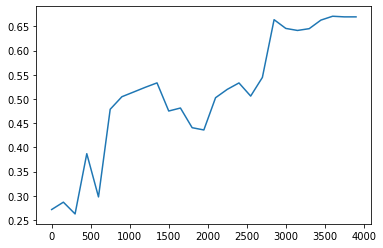

In [18]:
ite=np.linspace(0,3900,27)
plt.plot(ite,acc_array[0:27])
plt.show()

In [19]:
q = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc_value = np.round(acc(y, y_pred), 5)

    loss = np.round(loss, 5)
    print('Acc = %.5f' % (acc_value), ' ; loss=', loss)

Acc = 0.66960  ; loss= 1e-05


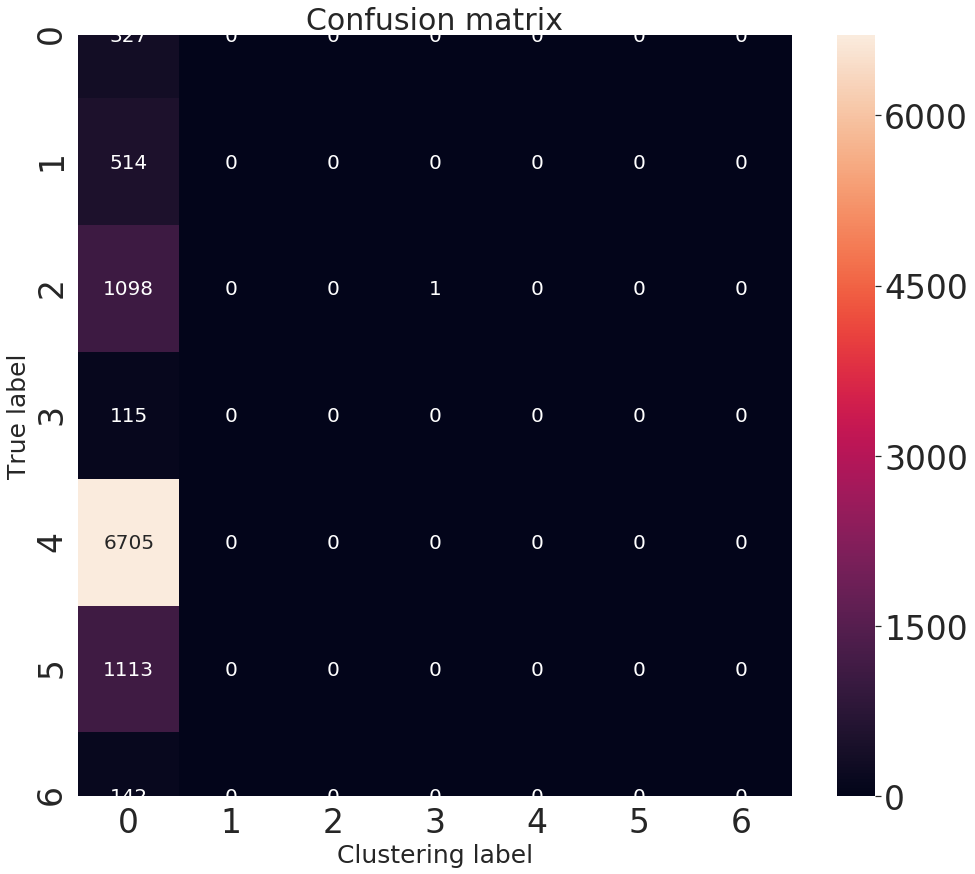

In [20]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

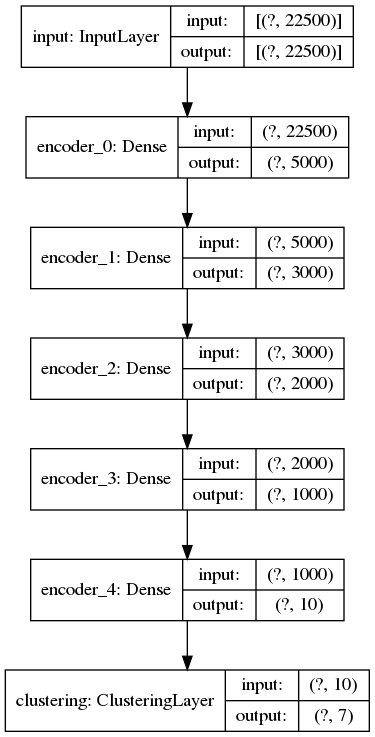

In [21]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png') 

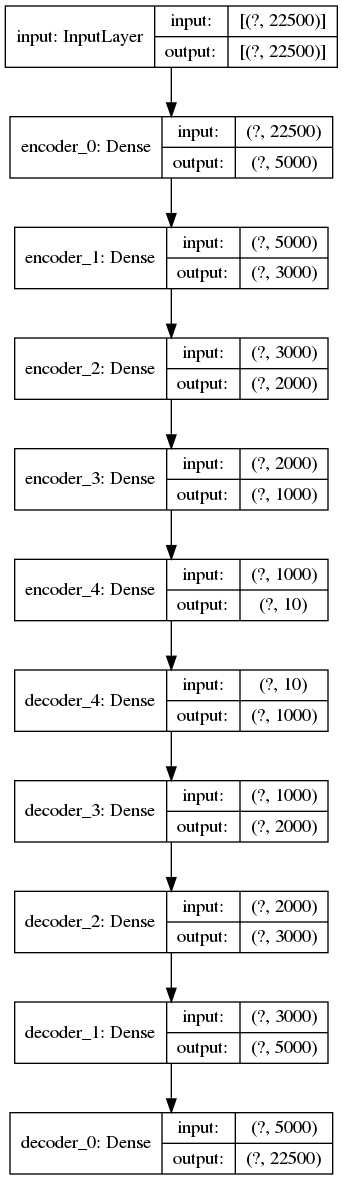

In [22]:
plot_model(autoencoder, to_file='aemodel.png', show_shapes=True)
Image(filename='aemodel.png') 